<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/Beautweenness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Основной код - расчет navigational betweenness

На вход граф в виде - (adj_matrix - матрица смежности) и (dist_matrix - матрица расстояний)

In [1]:
def create_disc_levels(dist_matrix, t, n): # функция для разбивки графа на уровни по метрике

    distances_from_t = dist_matrix[t]

    vertex_distances = [(dist, vertex) for vertex, dist in enumerate(distances_from_t)]

    vertex_distances.sort(key=lambda x: x[0])

    disc = []
    current_level_num = 0
    current_level = []
    current_distance = None

    for dist, vertex in vertex_distances:
        if dist != current_distance:
            if current_level:
                disc.append((current_level_num, current_level))
                current_level_num += 1
            current_level = [vertex]
            current_distance = dist
        else:
            current_level.append(vertex)

    if current_level:
        disc.append((current_level_num, current_level))

    return disc

def calculate_navigational_betweenness(adj_matrix, dist_matrix): # основная функция с алгоритмом
  n = len(adj_matrix)
  neighbors = []
  for v in range(n):
    neighbors_v = [i for i in range(n) if adj_matrix[v][i] == 1]
    neighbors.append(neighbors_v)
  delta = [[None for i in range(n)] for j in range(n)]

  for t in range(n):
    # инициализация рабочих списков
    con = [0] * n
    n_t, p_t = [[] for i in range(n)], [[] for i in range(n)]
    sigma_t = [0] * n

    # 1) вычисление уровней
    disc = create_disc_levels(dist_matrix, t, n)

    # инициализация в t
    con[t] = 1
    sigma_t[t] = None

    # 2) BFS в одну сторону с получением списков n_t, p_t
    for level in disc:
      if level[0] != 0:
        for vertex in level[1]:
          min_neighbors_dist = None
          for neighbor in neighbors[vertex]:
            if (min_neighbors_dist is None) or (dist_matrix[t][neighbor] < min_neighbors_dist):
              min_neighbors_dist = dist_matrix[t][neighbor]

          for neighbor in neighbors[vertex]:
            if (con[neighbor] == 1) and (dist_matrix[t][neighbor] == min_neighbors_dist) and (min_neighbors_dist < dist_matrix[t][vertex]):
              n_t[vertex].append(neighbor)
              if sigma_t[neighbor] is None:
                sigma_t[vertex] = 1
              else:
                sigma_t[vertex] += sigma_t[neighbor]
              con[vertex] = 1
              p_t[neighbor].append(vertex)

    # 3) BFS в обратную с получением delta
    level_max_num = disc[-1][0]
    level_max = disc[level_max_num][1]
    for vertex in level_max:
      delta[t][vertex] = 0

    level_num = level_max_num - 1
    while level_num > 0:
      level = disc[level_num][1]
      for vertex in level:
        delta[t][vertex] = 0
        for u in p_t[vertex]:
          delta[t][vertex] += (sigma_t[vertex]/sigma_t[u]) * (delta[t][u] + 1)
      level_num -= 1

  # подсчет navigational betweenness
  B_nav = [0] * n
  for vertex in range(n):
    for t in range(n):
      if t != vertex:
        B_nav[vertex] += delta[t][vertex]

  return B_nav

Посмотрим на простейших графах с метрикой - квадратных решетках n на n

In [2]:
import math

def make_lattice(n): # задаем матрицы для решетки по размеру
  adj_matrix = [[0 for i in range(n ** 2)] for j in range(n ** 2)]
  dist_matrix = [[0 for i in range(n ** 2)] for j in range(n ** 2)]

  for i in range(n ** 2):
    for j in range(n ** 2):
      if ((abs(i // n - j // n) == 1) and (i % n == j % n)) or ((abs(i % n - j % n) == 1) and (i // n == j // n)):
        adj_matrix[i][j] = 1
      dist_matrix[i][j] = math.sqrt((i // n - j // n) ** 2 + (i % n - j % n) ** 2)

  return adj_matrix, dist_matrix

def lattice_to_table(lattice_list, n): # превращаем список на вершинах решетки в квадратную таблицу для наглядности
  table = [[0 for i in range(n)] for j in range(n)]

  index = 0
  for k in lattice_list:
    table[index // n][index % n] = k
    index += 1

  return table

Для сравнения - посчитаем navigational betweenness для решеток "жадным" способом

In [3]:
def coordinates_transform(t, v, s, n): # вспомогательная функция для работы с представлением решетки в виде списка
  if (t // n <= s // n) and (t % n >= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = v // n - t // n, t % n - v % n
    x_s, y_s = s // n - t // n, t % n - s % n
  elif (t // n <= s // n) and (t % n <= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = v // n - t // n, v % n - t % n
    x_s, y_s = s // n - t // n, s % n - t % n
  elif (t // n >= s // n) and (t % n >= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = t // n - v // n, t % n - v % n
    x_s, y_s = t // n - s // n, t % n - s % n
  elif (t // n >= s // n) and (t % n <= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = t // n - v // n, v % n - t % n
    x_s, y_s = t // n - s // n, s % n - t % n

  if y_s > x_s:
    x_s, y_s = y_s, x_s
    x_v, y_v = y_v, x_v

  return ((x_v, y_v), (x_s, y_s))

def calculate_greedy_lattice(n): # основная функция
  B_nav = []
  for v in range(n ** 2):
    B_nav_v = 0
    for s in range(n ** 2):
      for t in range(n ** 2):
        if (s != t) and (v != s) and (v != t):
          (x_v, y_v), (x_s, y_s) = coordinates_transform(t, v, s, n)
          if ((y_v == y_s) and (x_v < x_s) and (y_s < x_v)) or ((x_v == y_v) and (y_v <= y_s) and (y_v >= 0)):
            B_nav_v += 1
          elif ((x_v - y_v) in (-1, 1)) and (max(x_v, y_v) <= y_s) and (min(x_v, y_v) >= 0):
            B_nav_v += 1 / 2

    B_nav.append(B_nav_v)

  return B_nav

Сравним на маленьких решетках

In [4]:
n = 5

adj_matrix, dist_matrix = make_lattice(n)
B_nav = calculate_navigational_betweenness(adj_matrix, dist_matrix)
B_nav_table = lattice_to_table(B_nav, n)

B_nav_greedy = calculate_greedy_lattice(n)
B_nav_greedy_table = lattice_to_table(B_nav_greedy, n)

print(f'Расчет для решетки размера {n} через алгоритм:\n {B_nav_table}\n\n')
print(f'Расчет для решетки размера {n} через жадный алгоритм:\n {B_nav_greedy_table}')

Расчет для решетки размера 5 через алгоритм:
 [[4.0, 32.0, 38.0, 32.0, 4.0], [32.0, 94.0, 114.0, 94.0, 32.0], [38.0, 114.0, 144.0, 114.0, 38.0], [32.0, 94.0, 114.0, 94.0, 32.0], [4.0, 32.0, 38.0, 32.0, 4.0]]


Расчет для решетки размера 5 через жадный алгоритм:
 [[4.0, 32.0, 38.0, 32.0, 4.0], [32.0, 94.0, 114.0, 94.0, 32.0], [38.0, 114.0, 144.0, 114.0, 38.0], [32.0, 94.0, 114.0, 94.0, 32.0], [4.0, 32.0, 38.0, 32.0, 4.0]]


Прогоним сравнение на квадратных решетках

🚀 ЗАПУСК СРАВНЕНИЯ РЕШЕТОК РАЗНЫХ РАЗМЕРОВ

🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 2×2
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 2×2 (Размер 2×2)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [1.0, 1.0]
   Диапазон значений betweenness (жадный): [1.0, 1.0]
------------------------------------------------------------


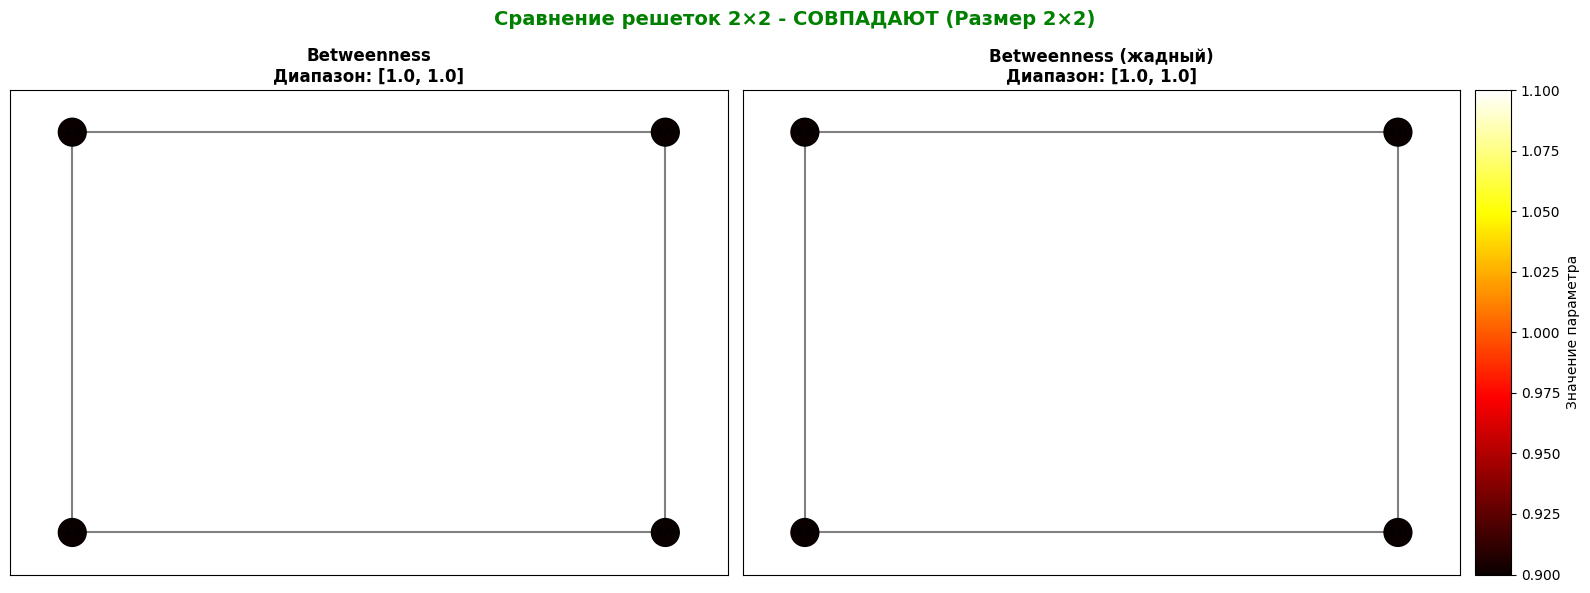

📊 Визуализация завершена для решетки 2×2


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 3×3
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 3×3 (Размер 3×3)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [2.0, 24.0]
   Диапазон значений betweenness (жадный): [2.0, 24.0]
------------------------------------------------------------


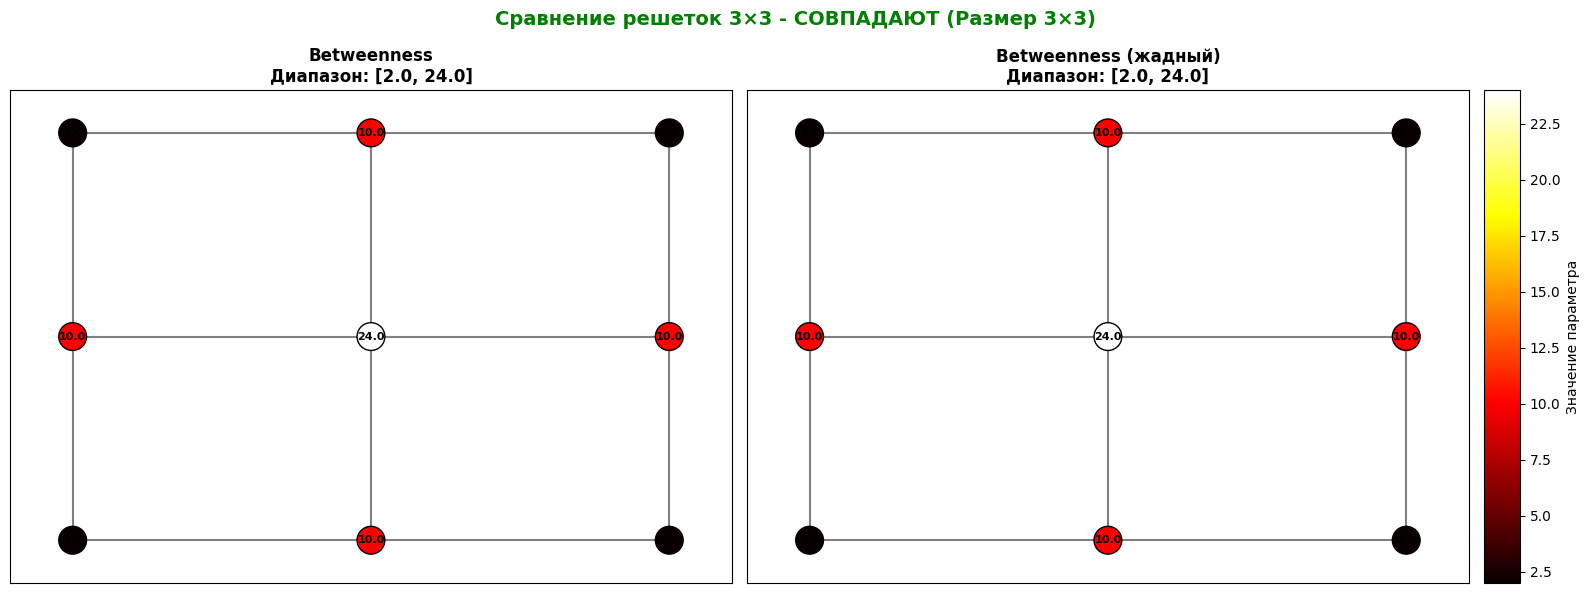

📊 Визуализация завершена для решетки 3×3


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 4×4
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 4×4 (Размер 4×4)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [3.0, 57.0]
   Диапазон значений betweenness (жадный): [3.0, 57.0]
------------------------------------------------------------


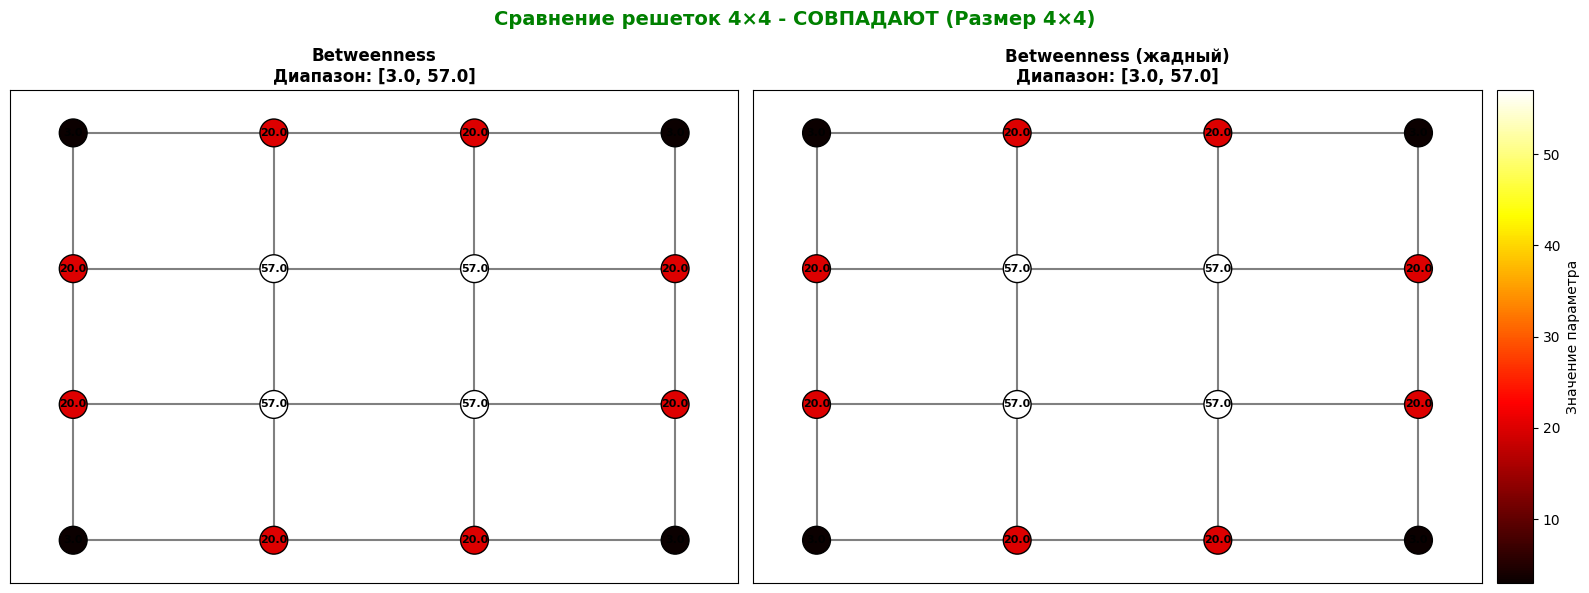

📊 Визуализация завершена для решетки 4×4


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 5×5
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 5×5 (Размер 5×5)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [4.0, 144.0]
   Диапазон значений betweenness (жадный): [4.0, 144.0]
------------------------------------------------------------


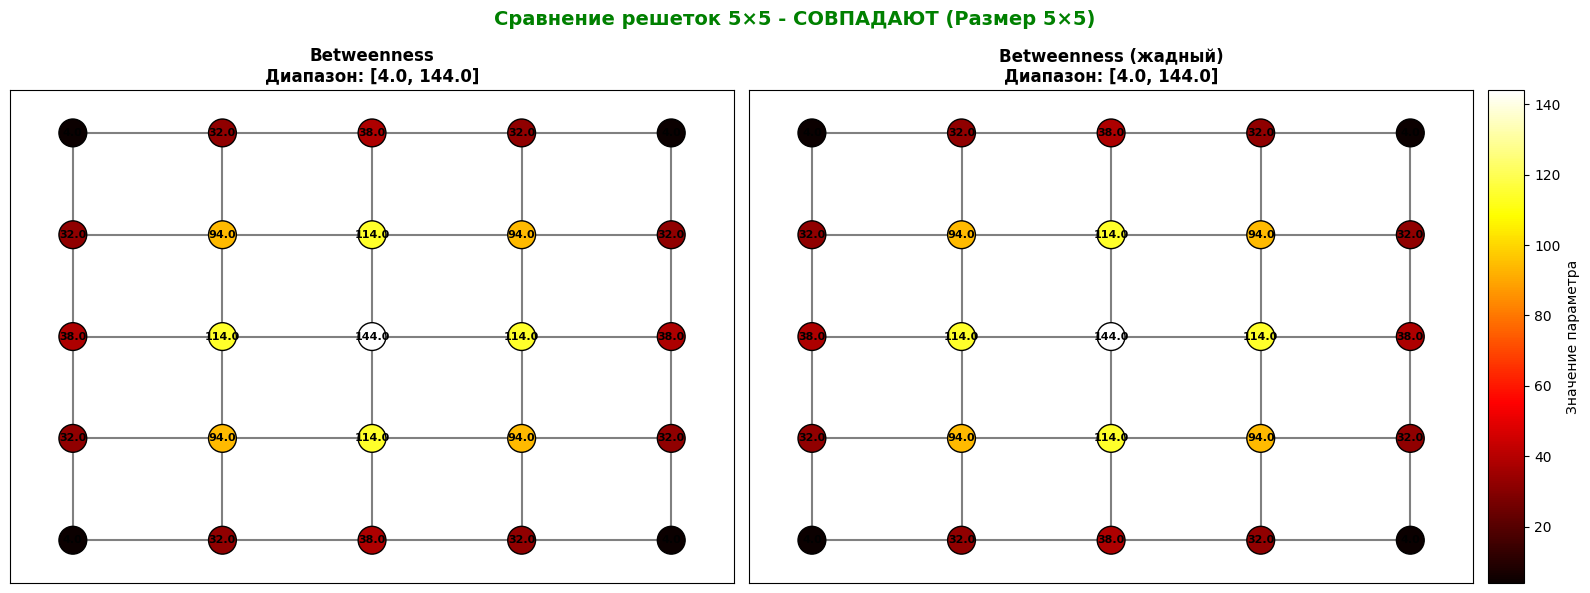

📊 Визуализация завершена для решетки 5×5


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 6×6
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 6×6 (Размер 6×6)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [5.0, 243.0]
   Диапазон значений betweenness (жадный): [5.0, 243.0]
------------------------------------------------------------


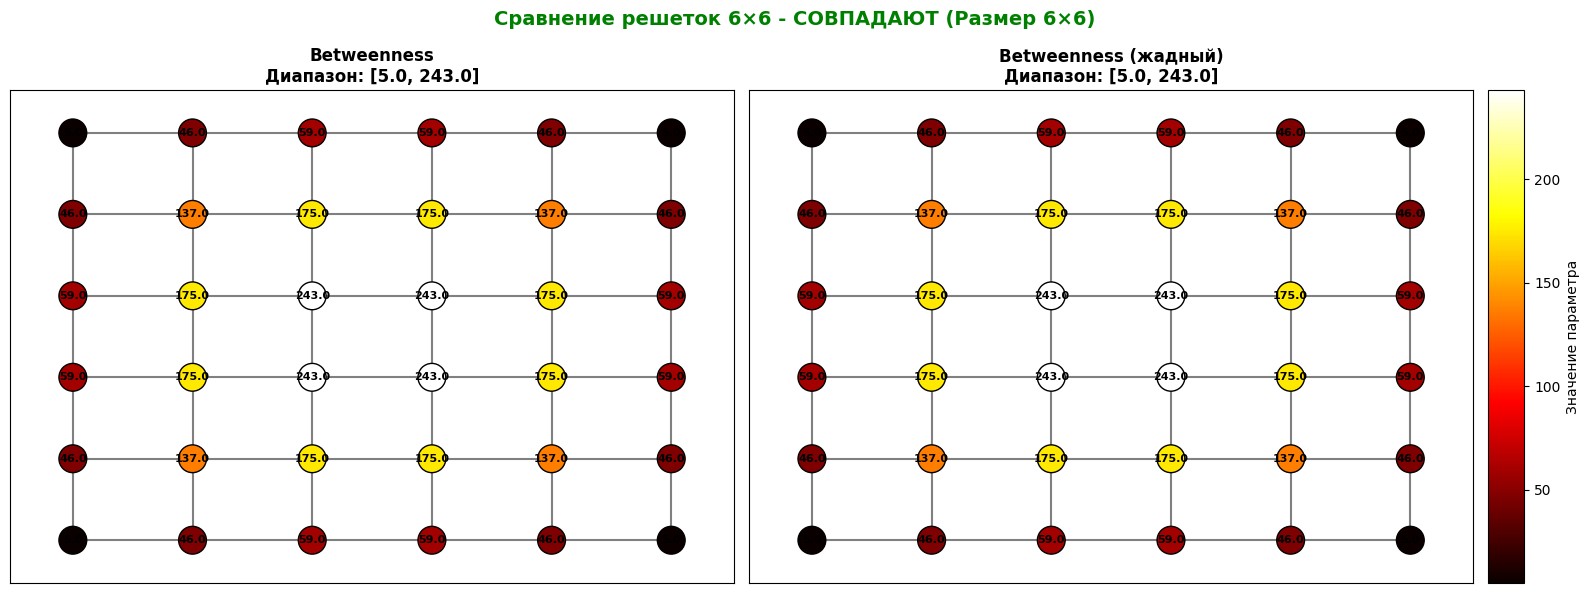

📊 Визуализация завершена для решетки 6×6


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 7×7
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 7×7 (Размер 7×7)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [6.0, 432.0]
   Диапазон значений betweenness (жадный): [6.0, 432.0]
------------------------------------------------------------


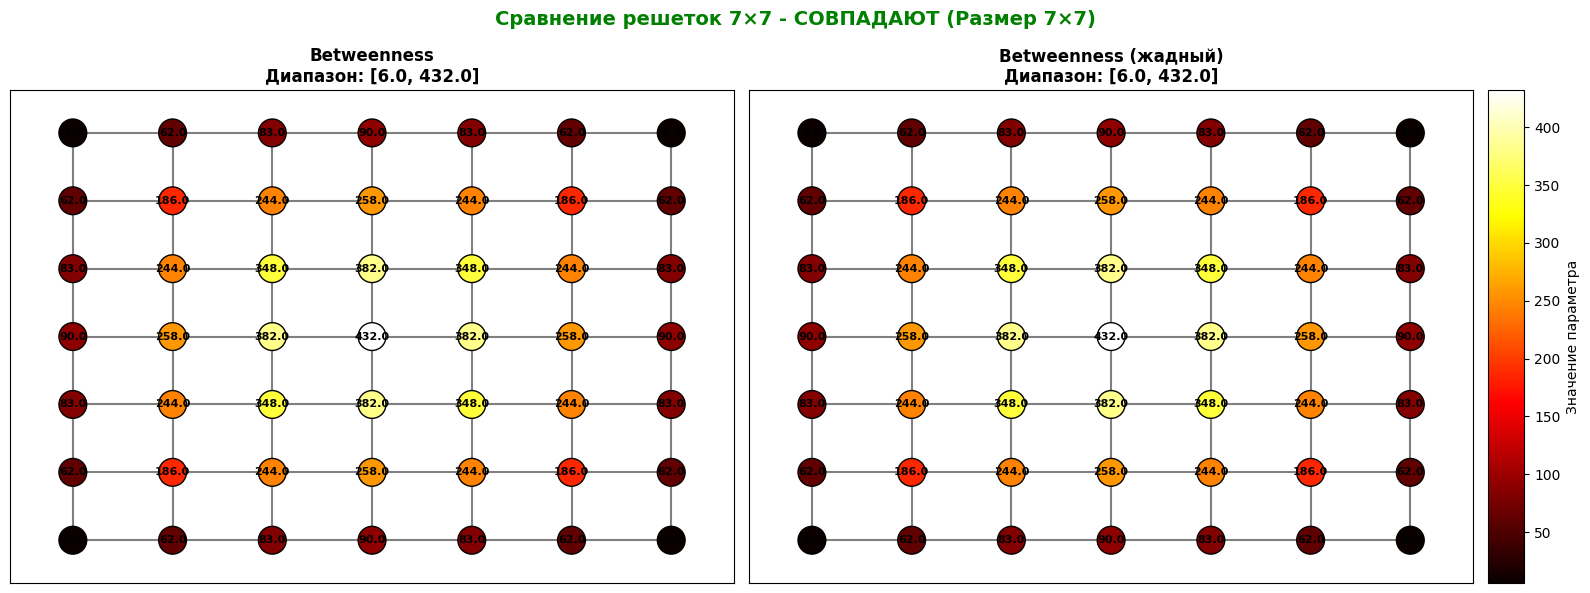

📊 Визуализация завершена для решетки 7×7


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 8×8
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 8×8 (Размер 8×8)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [7.0, 631.0]
   Диапазон значений betweenness (жадный): [7.0, 631.0]
------------------------------------------------------------


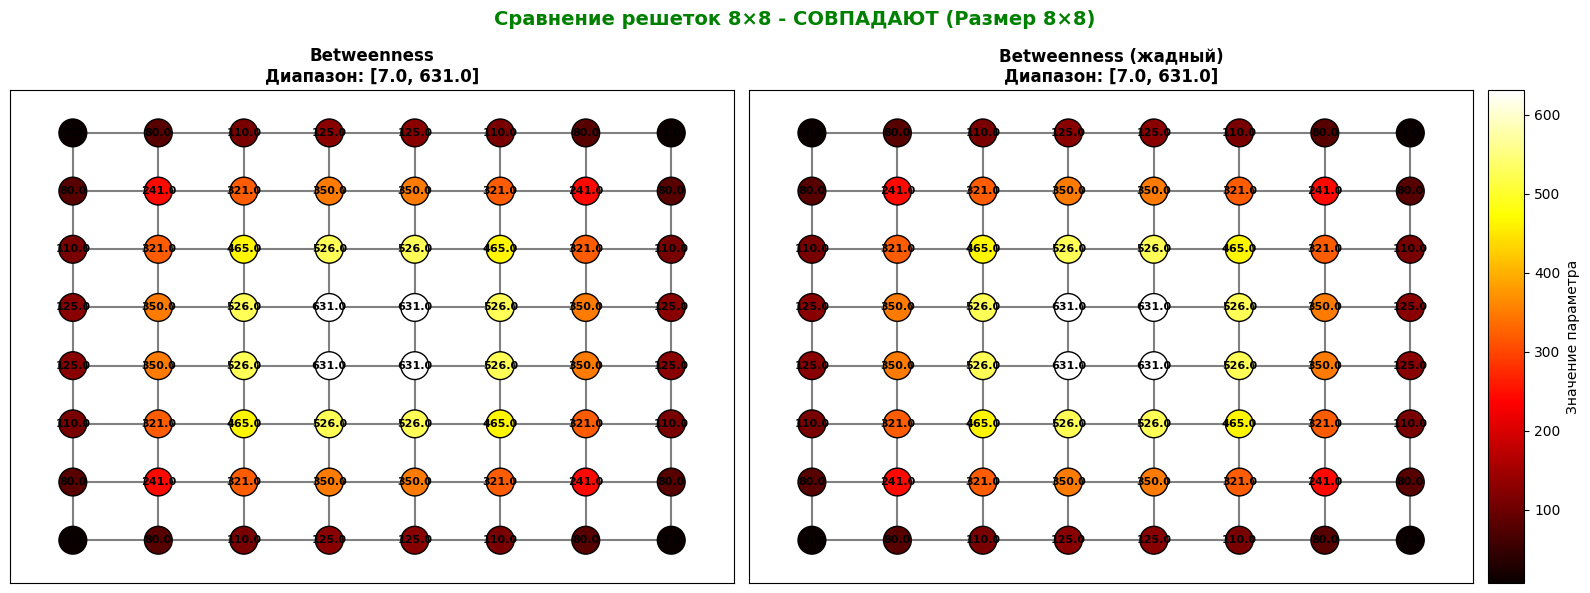

📊 Визуализация завершена для решетки 8×8


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 9×9
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 9×9 (Размер 9×9)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [8.0, 960.0]
   Диапазон значений betweenness (жадный): [8.0, 960.0]
------------------------------------------------------------


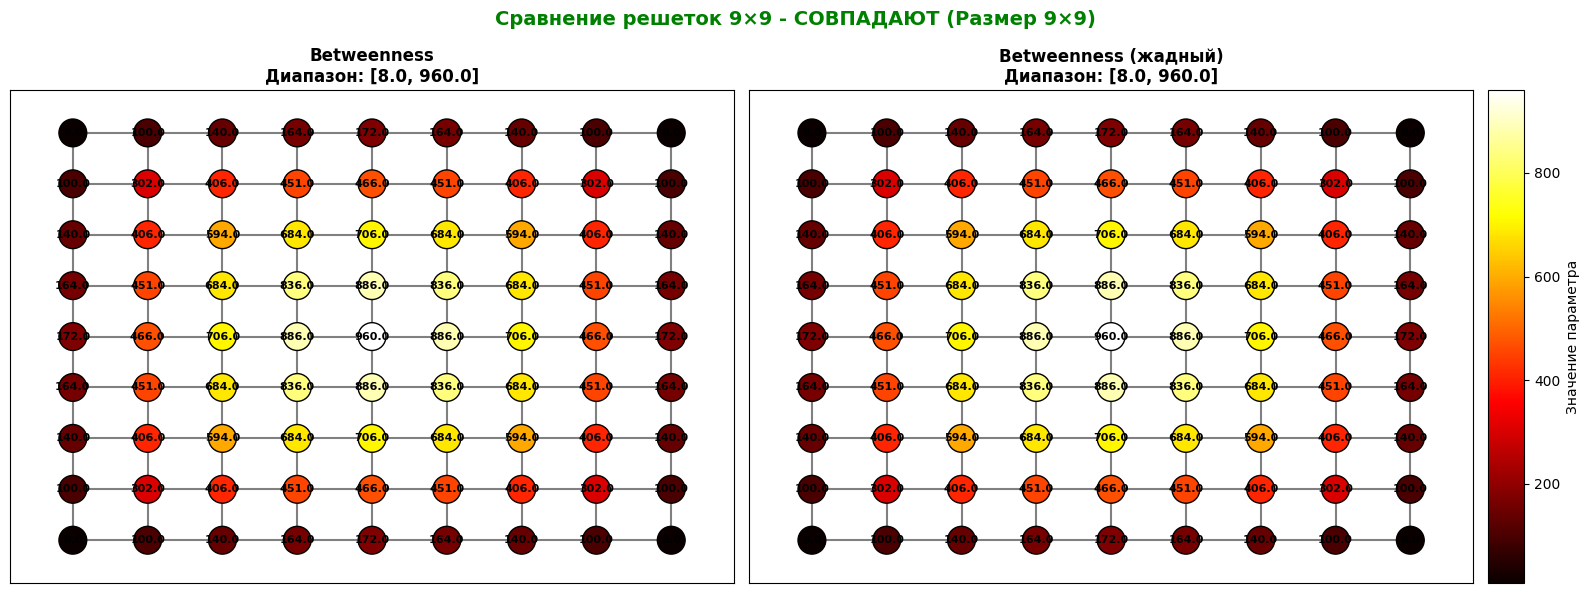

📊 Визуализация завершена для решетки 9×9


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 10×10
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 10×10 (Размер 10×10)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [9.0, 1293.0]
   Диапазон значений betweenness (жадный): [9.0, 1293.0]
------------------------------------------------------------


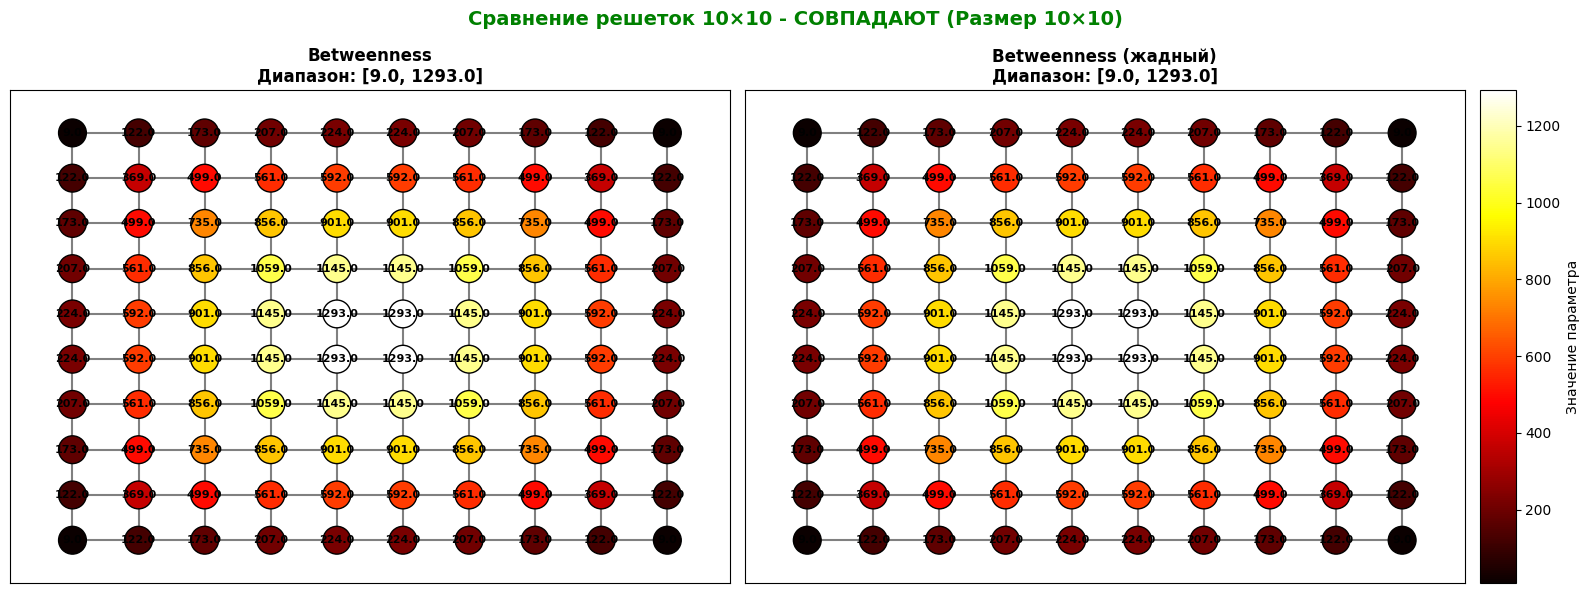

📊 Визуализация завершена для решетки 10×10


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 11×11
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 11×11 (Размер 11×11)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [10.0, 1800.0]
   Диапазон значений betweenness (жадный): [10.0, 1800.0]
------------------------------------------------------------


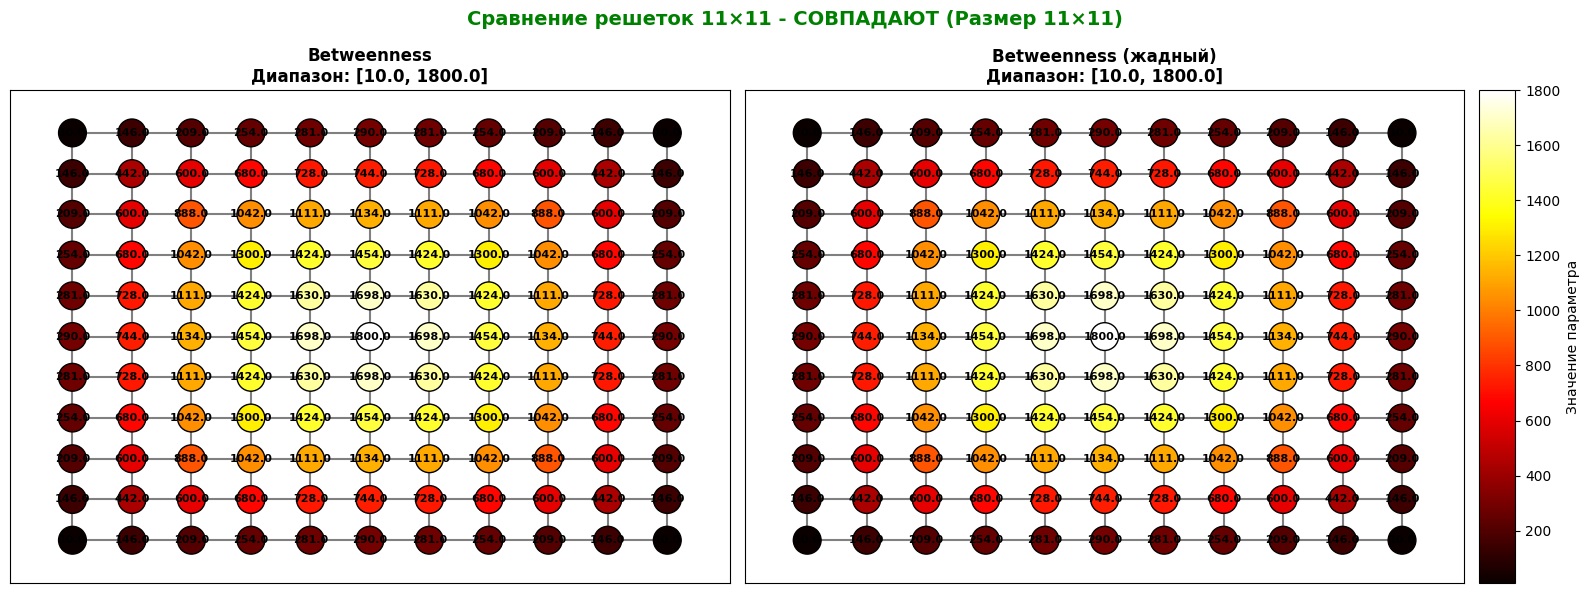

📊 Визуализация завершена для решетки 11×11


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 12×12
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 12×12 (Размер 12×12)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [11.0, 2301.0]
   Диапазон значений betweenness (жадный): [11.0, 2301.0]
------------------------------------------------------------


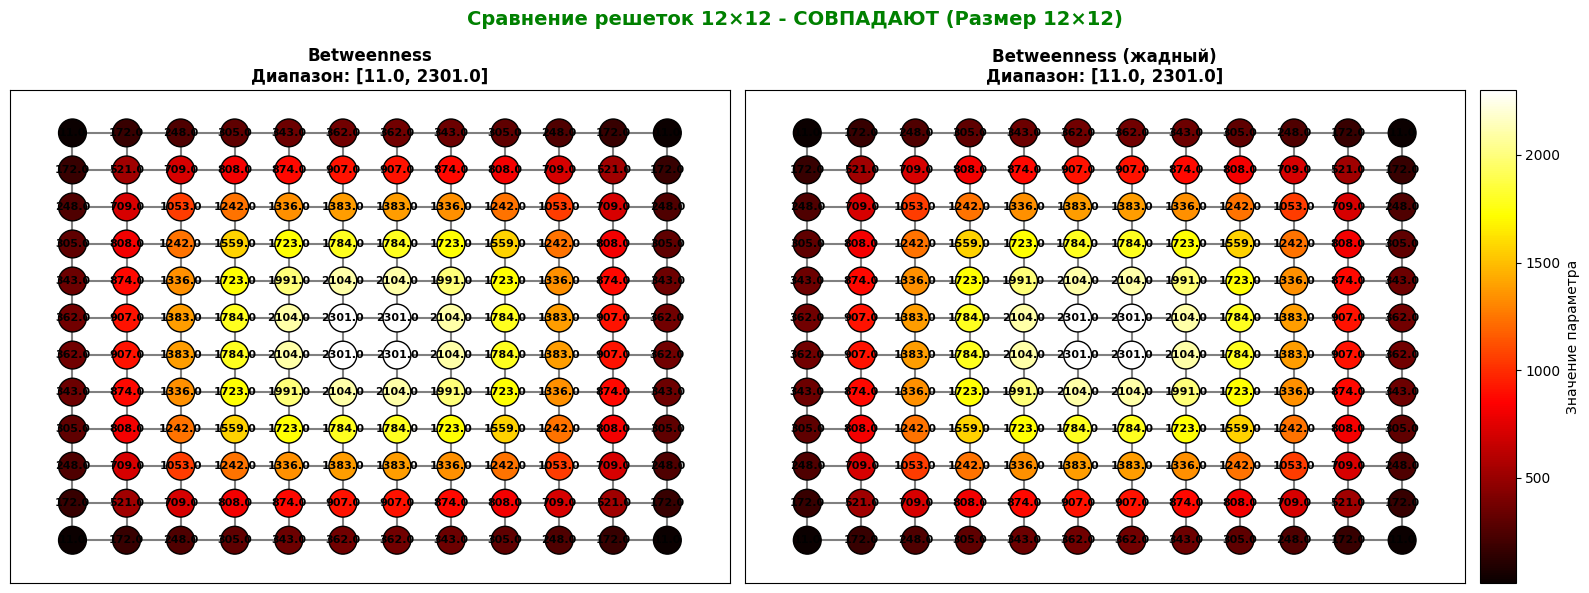

📊 Визуализация завершена для решетки 12×12


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 13×13
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 13×13 (Размер 13×13)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [12.0, 3024.0]
   Диапазон значений betweenness (жадный): [12.0, 3024.0]
------------------------------------------------------------


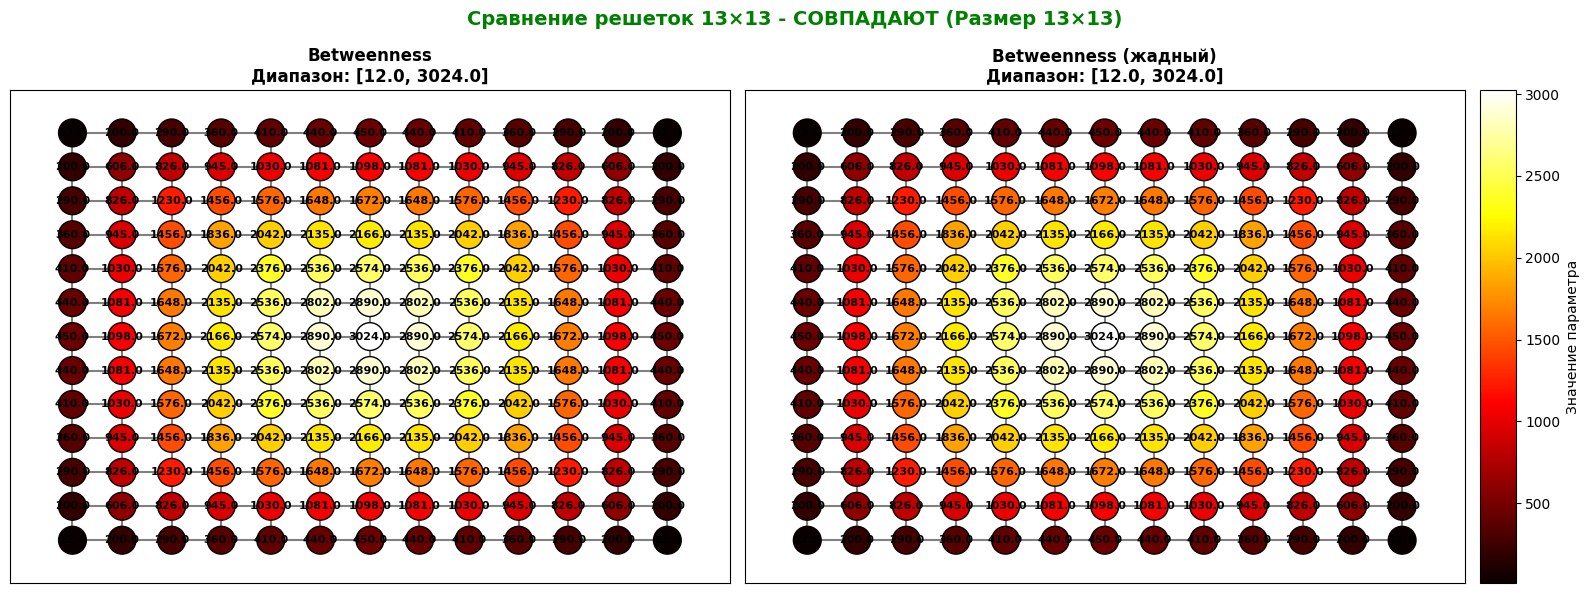

📊 Визуализация завершена для решетки 13×13


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 14×14
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 14×14 (Размер 14×14)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [13.0, 3727.0]
   Диапазон значений betweenness (жадный): [13.0, 3727.0]
------------------------------------------------------------


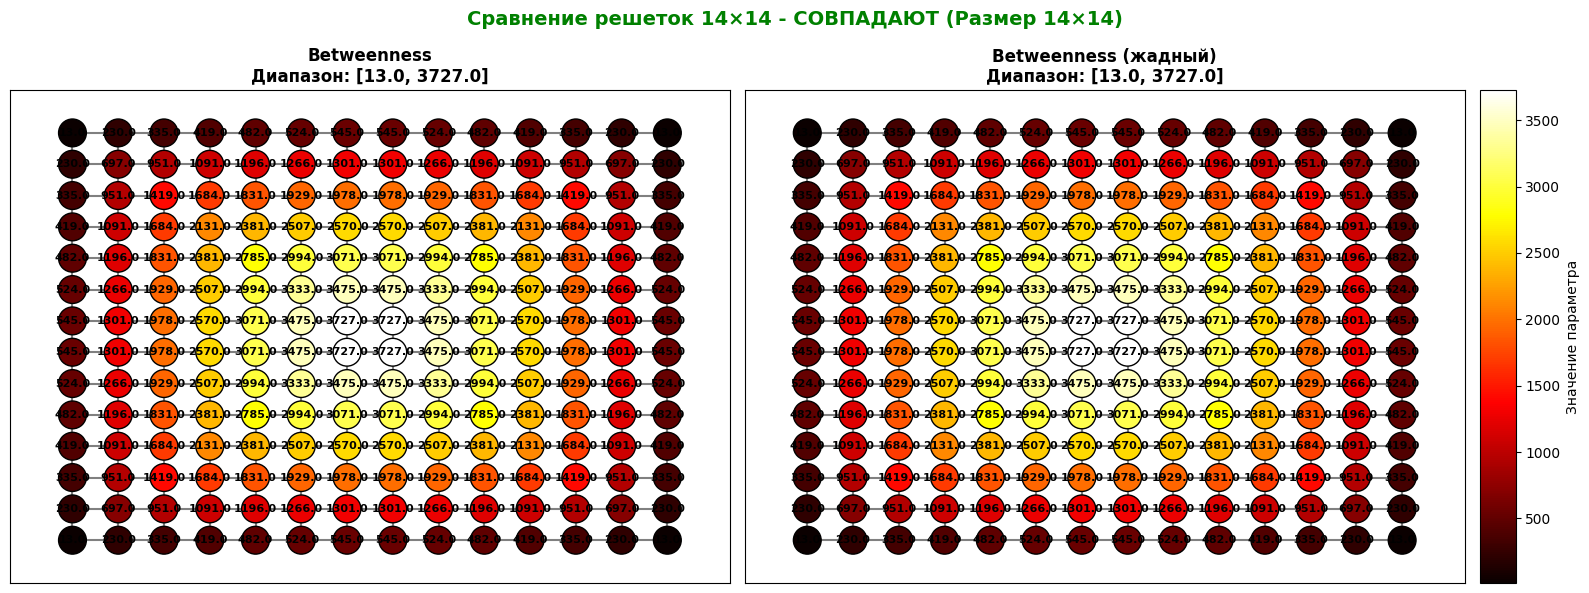

📊 Визуализация завершена для решетки 14×14


🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА 15×15
--------------------------------------------------
СРАВНЕНИЕ РЕШЕТОК 15×15 (Размер 15×15)
✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!
   Диапазон значений betweenness: [14.0, 4704.0]
   Диапазон значений betweenness (жадный): [14.0, 4704.0]
------------------------------------------------------------


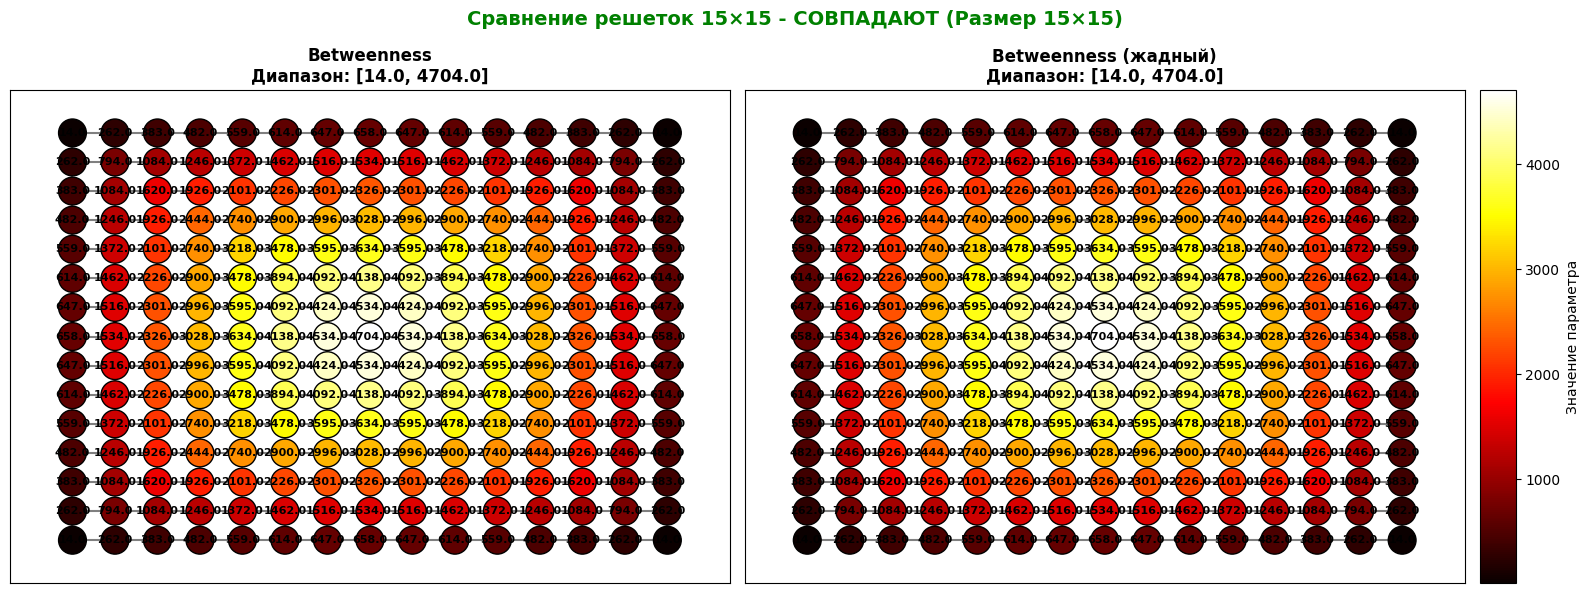

📊 Визуализация завершена для решетки 15×15


📋 ИТОГОВАЯ СВОДКА ПО ВСЕМ РАЗМЕРАМ:
   Решетка 2×2: ✅ СОВПАДАЮТ
   Решетка 3×3: ✅ СОВПАДАЮТ
   Решетка 4×4: ✅ СОВПАДАЮТ
   Решетка 5×5: ✅ СОВПАДАЮТ
   Решетка 6×6: ✅ СОВПАДАЮТ
   Решетка 7×7: ✅ СОВПАДАЮТ
   Решетка 8×8: ✅ СОВПАДАЮТ
   Решетка 9×9: ✅ СОВПАДАЮТ
   Решетка 10×10: ✅ СОВПАДАЮТ
   Решетка 11×11: ✅ СОВПАДАЮТ
   Решетка 12×12: ✅ СОВПАДАЮТ
   Решетка 13×13: ✅ СОВПАДАЮТ
   Решетка 14×14: ✅ СОВПАДАЮТ
   Решетка 15×15: ✅ СОВПАДАЮТ


In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import gridspec

def compare_and_visualize_grids(table1, table2, title_suffix="", node_size=600, figsize=(16, 6)):
    """
    Сравнивает две таблицы и визуализирует их графы-решетки рядом

    Parameters:
    table1, table2: таблицы n x n с числами
    title_suffix: дополнительная информация для заголовка
    node_size: размер вершин
    figsize: размер фигуры
    """
    n1, n2 = len(table1), len(table2)

    # Проверка совпадения размеров
    if n1 != n2 or any(len(row1) != len(row2) for row1, row2 in zip(table1, table2)):
        print("❌ ОШИБКА: Размеры таблиц не совпадают!")
        return None, False

    n = n1
    table1_array = np.array(table1)
    table2_array = np.array(table2)

    # Сравнение значений
    are_identical = np.array_equal(table1_array, table2_array)

    # Текстовая сводка
    print("=" * 60)
    print(f"СРАВНЕНИЕ РЕШЕТОК {n}×{n} {title_suffix}")
    print("=" * 60)

    if are_identical:
        print("✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!")
    else:
        print("❌ Решетки РАЗЛИЧАЮТСЯ")
        diff_count = np.sum(table1_array != table2_array)
        max_diff = np.max(np.abs(table1_array - table2_array))
        print(f"   Количество различных вершин: {diff_count}/{n*n}")
        print(f"   Максимальная разность: {max_diff:.2f}")

    print(f"   Диапазон значений betweenness: [{np.min(table1_array)}, {np.max(table1_array)}]")
    print(f"   Диапазон значений betweenness (жадный): [{np.min(table2_array)}, {np.max(table2_array)}]")
    print("-" * 60)

    # Создание графов
    G1 = nx.grid_2d_graph(n, n)
    G2 = nx.grid_2d_graph(n, n)

    # Позиции вершин
    pos = {(i, j): (j, -i) for i in range(n) for j in range(n)}

    # Метки вершин
    labels1 = {(i, j): table1_array[i, j] for i in range(n) for j in range(n)}
    labels2 = {(i, j): table2_array[i, j] for i in range(n) for j in range(n)}

    # Нормализация для цветовой схемы (общая для обоих графов)
    all_values = np.concatenate([table1_array.flatten(), table2_array.flatten()])
    vmin, vmax = np.min(all_values), np.max(all_values)

    # Создание фигуры
    fig = plt.figure(figsize=figsize)

    # Создание подграфиков
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    cax = plt.subplot(gs[2])

    # Визуализация первого графа
    node_colors1 = [table1_array[i, j] for i in range(n) for j in range(n)]
    nodes1 = nx.draw_networkx_nodes(G1, pos, ax=ax1,
                                   node_size=node_size,
                                   node_color=node_colors1,
                                   cmap='hot',
                                   vmin=vmin, vmax=vmax,
                                   edgecolors='black')

    nx.draw_networkx_edges(G1, pos, ax=ax1, edge_color='gray', width=1.5)
    nx.draw_networkx_labels(G1, pos, labels=labels1, ax=ax1,
                           font_size=8, font_weight='bold')

    ax1.set_title(f'Betweenness\nДиапазон: [{np.min(table1_array)}, {np.max(table1_array)}]',
                 fontsize=12, fontweight='bold')
    ax1.axis('on')
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Визуализация второго графа
    node_colors2 = [table2_array[i, j] for i in range(n) for j in range(n)]
    nodes2 = nx.draw_networkx_nodes(G2, pos, ax=ax2,
                                   node_size=node_size,
                                   node_color=node_colors2,
                                   cmap='hot',
                                   vmin=vmin, vmax=vmax,
                                   edgecolors='black')

    nx.draw_networkx_edges(G2, pos, ax=ax2, edge_color='gray', width=1.5)
    nx.draw_networkx_labels(G2, pos, labels=labels2, ax=ax2,
                           font_size=8, font_weight='bold')

    ax2.set_title(f'Betweenness (жадный)\nДиапазон: [{np.min(table2_array)}, {np.max(table2_array)}]',
                 fontsize=12, fontweight='bold')
    ax2.axis('on')
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Цветовая шкала
    sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Значение параметра', fontsize=10)

    # Общий заголовок
    status_text = "СОВПАДАЮТ" if are_identical else "РАЗЛИЧАЮТСЯ"
    status_color = "green" if are_identical else "red"
    fig.suptitle(f'Сравнение решеток {n}×{n} - {status_text} {title_suffix}',
                fontsize=14, fontweight='bold', color=status_color)

    plt.tight_layout()
    plt.show()

    print(f"📊 Визуализация завершена для решетки {n}×{n}\n")

    return are_identical

# Тестирование на разных размерах решеток

grid_sizes = [i for i in range(2, 16)]

print("🚀 ЗАПУСК СРАВНЕНИЯ РЕШЕТОК РАЗНЫХ РАЗМЕРОВ")
print("=" * 70)

results = {}

for size in grid_sizes:

    adj_matrix, dist_matrix = make_lattice(size)
    B_nav = calculate_navigational_betweenness(adj_matrix, dist_matrix)
    B_nav_table = lattice_to_table(B_nav, size)

    B_nav_greedy = calculate_greedy_lattice(size)
    B_nav_greedy_table = lattice_to_table(B_nav_greedy, size)

    print(f"\n🎯 АНАЛИЗ РЕШЕТКИ РАЗМЕРА {size}×{size}")
    print("-" * 50)

    # Сравниваем и визуализируем
    are_identical = compare_and_visualize_grids(
        B_nav_table, B_nav_greedy_table,
        title_suffix=f"(Размер {size}×{size})",
        node_size=400
    )

    results[size] = are_identical

# Итоговая сводка
print("\n" + "=" * 70)
print("📋 ИТОГОВАЯ СВОДКА ПО ВСЕМ РАЗМЕРАМ:")
print("=" * 70)
for size, identical in results.items():
    status = "✅ СОВПАДАЮТ" if identical else "❌ РАЗЛИЧАЮТСЯ"
    print(f"   Решетка {size}×{size}: {status}")

Сравним время работы на решетках

🚀 ЗАПУСК СРАВНЕНИЯ ПРОИЗВОДИТЕЛЬНОСТИ АЛГОРИТМОВ
Размер решетки Brandes (сек)   Greedy (сек)    Разница      Что быстрее    
--------------------------------------------------------------------------------
🔍 Тестирование решетки 3×3...
3×3        0.000152        0.000319        -0.000167 Brandes        
🔍 Тестирование решетки 5×5...
5×5        0.000726        0.007910        -0.007184 Brandes        
🔍 Тестирование решетки 7×7...
7×7        0.002662        0.048796        -0.046133 Brandes        
🔍 Тестирование решетки 10×10...
10×10       0.011387        0.430149        -0.418762 Brandes        
🔍 Тестирование решетки 12×12...
12×12       0.037715        1.294830        -1.257115 Brandes        
🔍 Тестирование решетки 15×15...
15×15       0.067642        5.118288        -5.050645 Brandes        
🔍 Тестирование решетки 18×18...
18×18       0.155711        15.376350       -15.220638 Brandes        
🔍 Тестирование решетки 21×21...
21×21       0.558508        39.086445       -38.527936 B

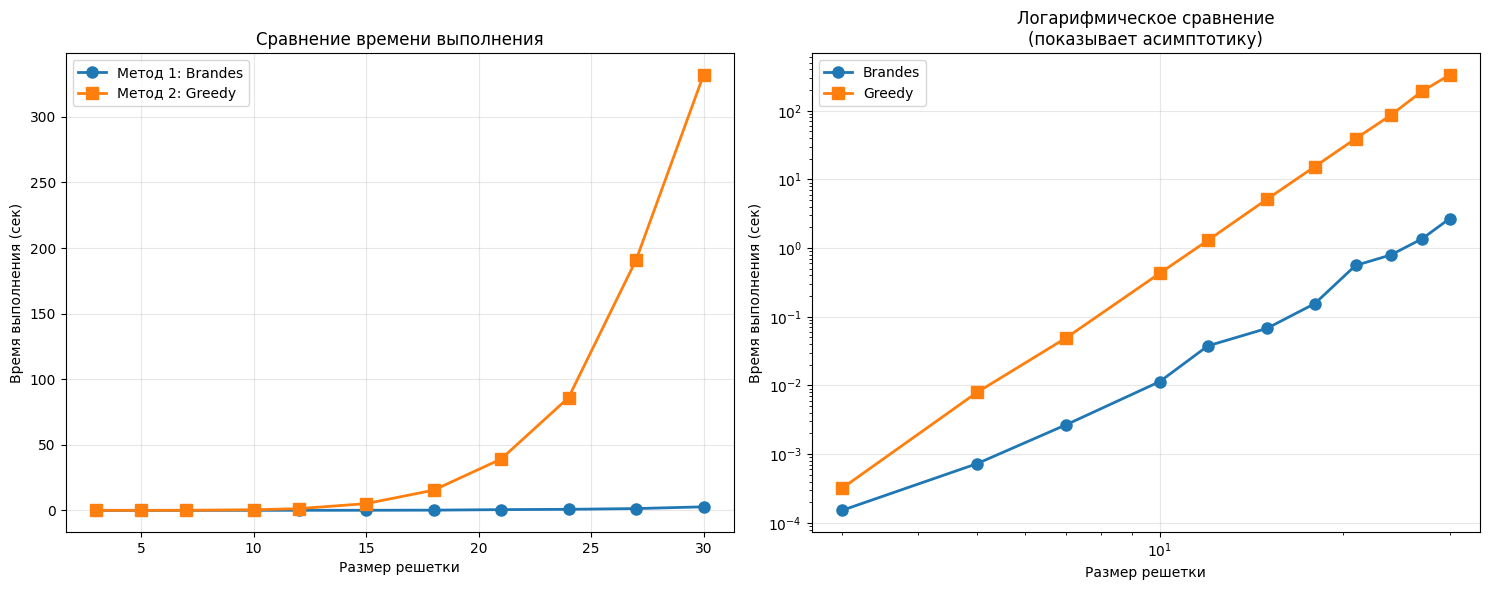


📈 ДЕТАЛЬНАЯ СВОДКА СРАВНЕНИЯ

🔍 РЕШЕТКА 3×3:
   ⏱️  Brandes: 0.000152 сек
   ⏱️  Greedy: 0.000319 сек
   🏆 Быстрее: Brandes (на 52.3%)

🔍 РЕШЕТКА 5×5:
   ⏱️  Brandes: 0.000726 сек
   ⏱️  Greedy: 0.007910 сек
   🏆 Быстрее: Brandes (на 90.8%)

🔍 РЕШЕТКА 7×7:
   ⏱️  Brandes: 0.002662 сек
   ⏱️  Greedy: 0.048796 сек
   🏆 Быстрее: Brandes (на 94.5%)

🔍 РЕШЕТКА 10×10:
   ⏱️  Brandes: 0.011387 сек
   ⏱️  Greedy: 0.430149 сек
   🏆 Быстрее: Brandes (на 97.4%)

🔍 РЕШЕТКА 12×12:
   ⏱️  Brandes: 0.037715 сек
   ⏱️  Greedy: 1.294830 сек
   🏆 Быстрее: Brandes (на 97.1%)

🔍 РЕШЕТКА 15×15:
   ⏱️  Brandes: 0.067642 сек
   ⏱️  Greedy: 5.118288 сек
   🏆 Быстрее: Brandes (на 98.7%)

🔍 РЕШЕТКА 18×18:
   ⏱️  Brandes: 0.155711 сек
   ⏱️  Greedy: 15.376350 сек
   🏆 Быстрее: Brandes (на 99.0%)

🔍 РЕШЕТКА 21×21:
   ⏱️  Brandes: 0.558508 сек
   ⏱️  Greedy: 39.086445 сек
   🏆 Быстрее: Brandes (на 98.6%)

🔍 РЕШЕТКА 24×24:
   ⏱️  Brandes: 0.793824 сек
   ⏱️  Greedy: 85.952591 сек
   🏆 Быстрее: Brandes (на 99.1%)



In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from collections import defaultdict

def compare_algorithms_performance(grid_sizes, num_runs=3):
    """
    Сравнивает время выполнения двух алгоритмов на решетках разных размеров

    Parameters:
    grid_sizes: список размеров решеток для тестирования
    num_runs: количество запусков для усреднения
    """

    print("🚀 ЗАПУСК СРАВНЕНИЯ ПРОИЗВОДИТЕЛЬНОСТИ АЛГОРИТМОВ")
    print("=" * 80)
    print(f"{'Размер решетки':<12} {'Brandes (сек)':<15} {'Greedy (сек)':<15} {'Разница':<12} {'Что быстрее':<15}")
    print("-" * 80)

    results = {}

    for size in grid_sizes:
        print(f"🔍 Тестирование решетки {size}×{size}...")

        # Измеряем время для первого метода
        times_method1 = []
        for _ in range(num_runs):
            adj_matrix, dist_matrix = make_lattice(size)
            start_time = time.time()
            result1 = calculate_navigational_betweenness(adj_matrix, dist_matrix)
            end_time = time.time()
            times_method1.append(end_time - start_time)

        # Измеряем время для второго метода
        times_method2 = []
        for _ in range(num_runs):
            start_time = time.time()
            result2 = calculate_greedy_lattice(size)
            end_time = time.time()
            times_method2.append(end_time - start_time)

        # Усредняем результаты
        avg_time1 = np.mean(times_method1)
        avg_time2 = np.mean(times_method2)

        # Определяем какой метод быстрее и на сколько
        time_diff = avg_time1 - avg_time2
        if time_diff > 0:
            faster = "Greedy"
            faster_time = avg_time2
            diff_percent = (time_diff / avg_time1) * 100
        else:
            faster = "Brandes"
            faster_time = avg_time1
            diff_percent = (abs(time_diff) / avg_time2) * 100

        # Сохраняем результаты
        results[size] = {
            'time_method1': avg_time1,
            'time_method2': avg_time2,
            'faster': faster,
            'diff_percent': diff_percent,
            'result1': result1,
            'result2': result2
        }

        # Выводим строку результатов
        print(f"{size}×{size:<8} {avg_time1:<15.6f} {avg_time2:<15.6f} {time_diff:+.6f} {faster:<15}")

    print("=" * 80)
    return results

def analyze_results_comparison(results):
    """
    Анализирует и сравнивает результаты вычислений двух методов
    """
    print("\n📊 СРАВНЕНИЕ РЕЗУЛЬТАТОВ ВЫЧИСЛЕНИЙ")
    print("=" * 80)
    print(f"{'Размер':<10} {'Совпадение':<12} {'Макс.разность':<15} {'Ср.разность':<12} {'Больше значений':<15}")
    print("-" * 80)

    for size, data in results.items():
        result1 = data['result1']
        result2 = data['result2']

        # Сравниваем значения
        values1 = np.array(list(result1))
        values2 = np.array(list(result2))

        # Статистика сравнения
        are_identical = np.array_equal(values1, values2)
        max_diff = np.max(np.abs(values1 - values2))
        mean_diff = np.mean(np.abs(values1 - values2))

        # Каких значений больше
        count_greater1 = np.sum(values1 > values2)
        count_greater2 = np.sum(values2 > values1)
        count_equal = np.sum(values1 == values2)

        if count_greater1 > count_greater2:
            greater_text = f"Brandes ({count_greater1})"
        elif count_greater2 > count_greater1:
            greater_text = f"Greedy ({count_greater2})"
        else:
            greater_text = f"Одинаково ({count_greater1})"

        status = "✅ СОВПАДАЮТ" if are_identical else "❌ РАЗЛИЧАЮТСЯ"

        print(f"{size}×{size:<6} {status:<12} {max_diff:<15.6f} {mean_diff:<12.6f} {greater_text:<15}")

def plot_performance_comparison(results):
    """
    Строит графики сравнения производительности
    """
    sizes = list(results.keys())
    times1 = [results[size]['time_method1'] for size in sizes]
    times2 = [results[size]['time_method2'] for size in sizes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Линейный график
    ax1.plot(sizes, times1, 'o-', label='Метод 1: Brandes', linewidth=2, markersize=8)
    ax1.plot(sizes, times2, 's-', label='Метод 2: Greedy', linewidth=2, markersize=8)
    ax1.set_xlabel('Размер решетки')
    ax1.set_ylabel('Время выполнения (сек)')
    ax1.set_title('Сравнение времени выполнения')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Логарифмический график
    ax2.loglog(sizes, times1, 'o-', label='Brandes', linewidth=2, markersize=8)
    ax2.loglog(sizes, times2, 's-', label='Greedy', linewidth=2, markersize=8)
    ax2.set_xlabel('Размер решетки')
    ax2.set_ylabel('Время выполнения (сек)')
    ax2.set_title('Логарифмическое сравнение\n(показывает асимптотику)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_detailed_summary(results):
    """
    Выводит детальную сводку сравнения
    """
    print("\n" + "=" * 80)
    print("📈 ДЕТАЛЬНАЯ СВОДКА СРАВНЕНИЯ")
    print("=" * 80)

    # Анализ по размерам
    for size, data in results.items():
        print(f"\n🔍 РЕШЕТКА {size}×{size}:")
        print(f"   ⏱️  Brandes: {data['time_method1']:.6f} сек")
        print(f"   ⏱️  Greedy: {data['time_method2']:.6f} сек")
        print(f"   🏆 Быстрее: {data['faster']} (на {data['diff_percent']:.1f}%)")

    # Общая статистика
    faster_counts = defaultdict(int)
    for data in results.values():
        faster_counts[data['faster']] += 1

    print(f"\n📊 ОБЩАЯ СТАТИСТИКА:")
    print(f"   Всего протестировано размеров: {len(results)}")
    for method, count in faster_counts.items():
        print(f"   {method} был быстрее в {count} случаях")

# Основная программа
if __name__ == "__main__":
    # Размеры решеток для тестирования
    grid_sizes = [3, 5, 7, 10, 12, 15, 18, 21, 24, 27, 30]

    # Запускаем сравнение производительности
    results = compare_algorithms_performance(grid_sizes, num_runs=2)

    # Анализируем результаты вычислений
    analyze_results_comparison(results)

    # Строим графики
    plot_performance_comparison(results)

    # Выводим детальную сводку
    print_detailed_summary(results)

    # Дополнительный анализ для больших размеров
    print("\n" + "=" * 80)
    print("🔮 ПРОГНОЗ ДЛЯ БОЛЬШИХ РАЗМЕРОВ")
    print("=" * 80)

    # Простая экстраполяция
    if len(results) >= 2:
        last_size = max(results.keys())
        last_time1 = results[last_size]['time_method1']
        last_time2 = results[last_size]['time_method2']

        # Предполагаем квадратичный рост (типично для графовых алгоритмов)
        predicted_size = last_size * 2
        predicted_time1 = last_time1 * 4  # квадратичный рост
        predicted_time2 = last_time2 * 4

        print(f"Прогноз для решетки {predicted_size}×{predicted_size}:")
        print(f"   Brandes: ~{predicted_time1:.2f} сек")
        print(f"   Greedy: ~{predicted_time2:.2f} сек")

        if predicted_time1 < predicted_time2:
            print(f"   🏆 Рекомендуется: Brandes (будет быстрее на {(predicted_time2-predicted_time1):.2f} сек)")
        else:
            print(f"   🏆 Рекомендуется: Greedy (будет быстрее на {(predicted_time1-predicted_time2):.2f} сек)")

Теперь прямоугольные решетки m на k

In [13]:
def rectangular_coordinates_transform(t, v, s, n): # вспомогательная функция для работы с представлением решетки в виде списка
  if (t // n <= s // n) and (t % n >= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = v // n - t // n, t % n - v % n
    x_s, y_s = s // n - t // n, t % n - s % n
  elif (t // n <= s // n) and (t % n <= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = v // n - t // n, v % n - t % n
    x_s, y_s = s // n - t // n, s % n - t % n
  elif (t // n >= s // n) and (t % n >= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = t // n - v // n, t % n - v % n
    x_s, y_s = t // n - s // n, t % n - s % n
  elif (t // n >= s // n) and (t % n <= s % n):
    x_t, y_t = 0, 0
    x_v, y_v = t // n - v // n, v % n - t % n
    x_s, y_s = t // n - s // n, s % n - t % n

  if y_s > x_s:
    x_s, y_s = y_s, x_s
    x_v, y_v = y_v, x_v

  return ((x_v, y_v), (x_s, y_s))

def calculate_greedy_rectangular_lattice(m, k): # основная функция
  B_nav = []
  for v in range(m * k):
    B_nav_v = 0
    for s in range(m * k):
      for t in range(m * k):
        if (s != t) and (v != s) and (v != t):
          (x_v, y_v), (x_s, y_s) = rectangular_coordinates_transform(t, v, s, k)
          if ((y_v == y_s) and (x_v < x_s) and (y_s < x_v)) or ((x_v == y_v) and (y_v <= y_s) and (y_v >= 0)):
            B_nav_v += 1
          elif ((x_v - y_v) in (-1, 1)) and (max(x_v, y_v) <= y_s) and (min(x_v, y_v) >= 0):
            B_nav_v += 1 / 2

    B_nav.append(B_nav_v)

  return B_nav

In [14]:
import math

def make_rectangular_lattice(m, k): # задаем матрицы для решетки по размеру
  adj_matrix = [[0 for i in range(m * k)] for j in range(m * k)]
  dist_matrix = [[0 for i in range(m * k)] for j in range(m * k)]

  for i in range(m * k):
    for j in range(m * k):
      if ((abs(i // k - j // k) == 1) and (i % k == j % k)) or ((abs(i % k - j % k) == 1) and (i // k == j // k)):
        adj_matrix[i][j] = 1
      dist_matrix[i][j] = math.sqrt((i // k - j // k) ** 2 + (i % k - j % k) ** 2)

  return adj_matrix, dist_matrix

def rectangular_lattice_to_table(lattice_list, m, k): # превращаем список на вершинах решетки в квадратную таблицу для наглядности
  table = [[0 for i in range(k)] for j in range(m)]

  index = 0
  for l in lattice_list:
    table[index // k][index % k] = l
    index += 1

  return table

Сравнение


📊 СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ ДЛЯ РАЗНЫХ ФОРМ РЕШЕТОК
🚀 ЗАПУСК СРАВНЕНИЯ ПРОИЗВОДИТЕЛЬНОСТИ ДЛЯ ПРЯМОУГОЛЬНЫХ РЕШЕТОК
Размер решетки  Вершин   Brandes (сек)   Greedy (сек)    Разница      Что быстрее    
------------------------------------------------------------------------------------------
🔍 Тестирование решетки 2×3 (6 вершин)...
2×3          6        0.000090        0.000175        -0.000085 Brandes        
🔍 Тестирование решетки 3×3 (9 вершин)...
3×3          9        0.000200        0.000495        -0.000295 Brandes        
🔍 Тестирование решетки 3×4 (12 вершин)...
3×4          12       0.000348        0.001265        -0.000917 Brandes        
🔍 Тестирование решетки 4×3 (12 вершин)...
4×3          12       0.000278        0.002866        -0.002589 Brandes        
🔍 Тестирование решетки 4×5 (20 вершин)...
4×5          20       0.000797        0.006658        -0.005861 Brandes        
🔍 Тестирование решетки 5×2 (10 вершин)...
5×2          10       0.000199        0.000615       

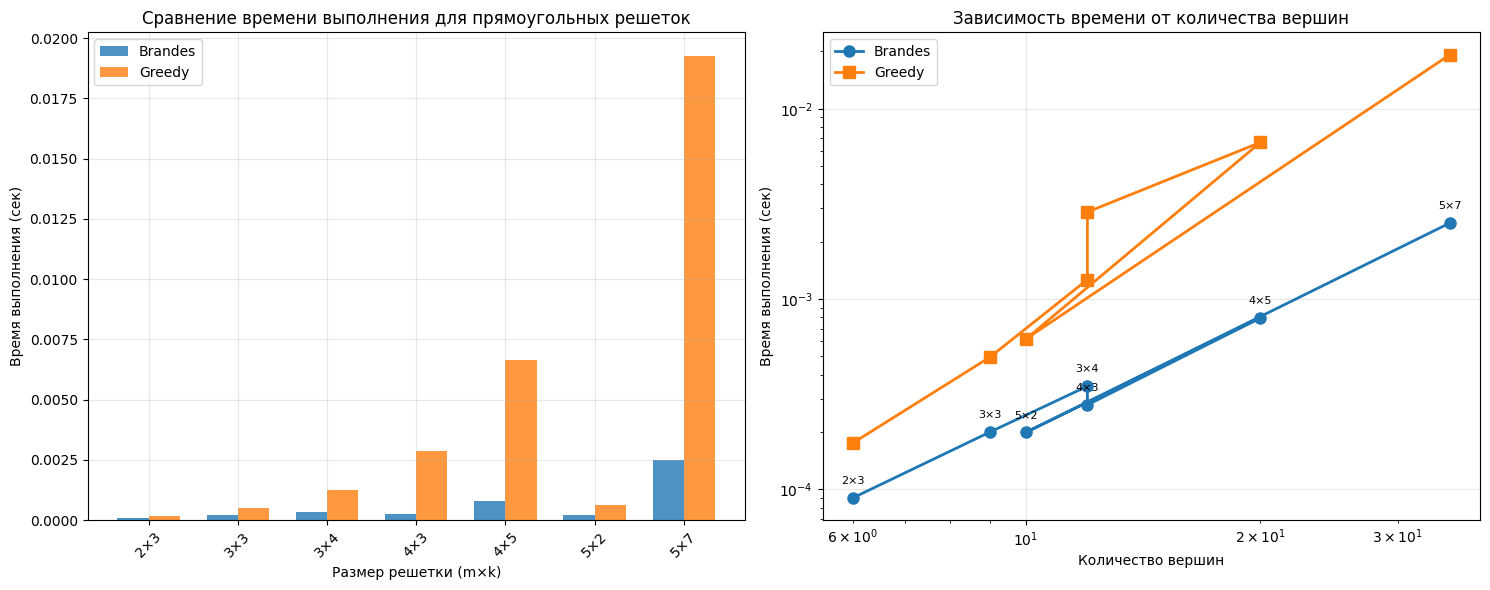

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import gridspec

def compare_and_visualize_rectangular_grids(table1, table2, title_suffix="", node_size=400, figsize=(16, 6)):
    """
    Сравнивает две таблицы и визуализирует их графы-решетки для прямоугольных сеток

    Parameters:
    table1, table2: таблицы m x k с числами
    title_suffix: дополнительная информация для заголовка
    node_size: размер вершин
    figsize: размер фигуры
    """
    m1, k1 = len(table1), len(table1[0])
    m2, k2 = len(table2), len(table2[0])

    # Проверка совпадения размеров
    if m1 != m2 or k1 != k2:
        print("❌ ОШИБКА: Размеры таблиц не совпадают!")
        print(f"   Brandes: {m1}×{k1}, Greedy: {m2}×{k2}")
        return None, False

    m, k = m1, k1
    table1_array = np.array(table1)
    table2_array = np.array(table2)

    # Сравнение значений
    are_identical = np.array_equal(table1_array, table2_array)

    # Текстовая сводка
    print("=" * 70)
    print(f"СРАВНЕНИЕ ПРЯМОУГОЛЬНЫХ РЕШЕТОК {m}×{k} {title_suffix}")
    print("=" * 70)

    if are_identical:
        print("✅ РЕШЕТКИ СОВПАЛИ - все значения идентичны!")
    else:
        print("❌ Решетки РАЗЛИЧАЮТСЯ")
        diff_count = np.sum(table1_array != table2_array)
        max_diff = np.max(np.abs(table1_array - table2_array))
        print(f"   Количество различных вершин: {diff_count}/{m*k}")
        print(f"   Максимальная разность: {max_diff:.2f}")

    print(f"   Диапазон значений Brandes: [{np.min(table1_array)}, {np.max(table1_array)}]")
    print(f"   Диапазон значений Greedy: [{np.min(table2_array)}, {np.max(table2_array)}]")
    print("-" * 70)

    # Создание графов
    G1 = nx.grid_2d_graph(m, k)  # m строк, k столбцов
    G2 = nx.grid_2d_graph(m, k)

    # Позиции вершин (учитываем прямоугольную форму)
    pos = {(i, j): (j, -i) for i in range(m) for j in range(k)}

    # Метки вершин
    labels1 = {(i, j): table1_array[i, j] for i in range(m) for j in range(k)}
    labels2 = {(i, j): table2_array[i, j] for i in range(m) for j in range(k)}

    # Нормализация для цветовой схемы (общая для обоих графов)
    all_values = np.concatenate([table1_array.flatten(), table2_array.flatten()])
    vmin, vmax = np.min(all_values), np.max(all_values)

    # Создание фигуры с учетом пропорций
    aspect_ratio = k / m  # соотношение сторон
    fig_width = max(8, 6 * aspect_ratio)
    figsize = (fig_width * 2 + 1, 6)  # два графа + цветовая шкала

    fig = plt.figure(figsize=figsize)

    # Создание подграфиков с учетом пропорций
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    cax = plt.subplot(gs[2])

    # Настройка размеров вершин в зависимости от размера решетки
    adaptive_node_size = max(200, node_size * 10 / max(m, k))

    # Визуализация первого графа
    node_colors1 = [table1_array[i, j] for i in range(m) for j in range(k)]
    nodes1 = nx.draw_networkx_nodes(G1, pos, ax=ax1,
                                   node_size=adaptive_node_size,
                                   node_color=node_colors1,
                                   cmap='hot',
                                   vmin=vmin, vmax=vmax,
                                   edgecolors='black')

    nx.draw_networkx_edges(G1, pos, ax=ax1, edge_color='gray', width=1.5)
    nx.draw_networkx_labels(G1, pos, labels=labels1, ax=ax1,
                           font_size=8, font_weight='bold')

    ax1.set_title(f'Brandes\nРазмер: {m}×{k}\nДиапазон: [{np.min(table1_array)}, {np.max(table1_array)}]',
                 fontsize=12, fontweight='bold')
    ax1.set_aspect('equal')
    ax1.axis('on')
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Визуализация второго графа
    node_colors2 = [table2_array[i, j] for i in range(m) for j in range(k)]
    nodes2 = nx.draw_networkx_nodes(G2, pos, ax=ax2,
                                   node_size=adaptive_node_size,
                                   node_color=node_colors2,
                                   cmap='hot',
                                   vmin=vmin, vmax=vmax,
                                   edgecolors='black')

    nx.draw_networkx_edges(G2, pos, ax=ax2, edge_color='gray', width=1.5)
    nx.draw_networkx_labels(G2, pos, labels=labels2, ax=ax2,
                           font_size=8, font_weight='bold')

    ax2.set_title(f'Greedy\nРазмер: {m}×{k}\nДиапазон: [{np.min(table2_array)}, {np.max(table2_array)}]',
                 fontsize=12, fontweight='bold')
    ax2.set_aspect('equal')
    ax2.axis('on')
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Цветовая шкала
    sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Значение параметра', fontsize=10)

    # Общий заголовок
    status_text = "СОВПАДАЮТ" if are_identical else "РАЗЛИЧАЮТСЯ"
    status_color = "green" if are_identical else "red"
    fig.suptitle(f'Сравнение прямоугольных решеток {m}×{k} - {status_text} {title_suffix}',
                fontsize=14, fontweight='bold', color=status_color)

    plt.tight_layout()
    plt.show()

    print(f"📊 Визуализация завершена для решетки {m}×{k}\n")

    return are_identical

def compare_algorithms_performance_rectangular(grid_sizes, num_runs=2):
    """
    Сравнивает время выполнения двух алгоритмов на прямоугольных решетках

    Parameters:
    grid_sizes: список кортежей (m, k) - размеров решеток для тестирования
    num_runs: количество запусков для усреднения
    """

    print("🚀 ЗАПУСК СРАВНЕНИЯ ПРОИЗВОДИТЕЛЬНОСТИ ДЛЯ ПРЯМОУГОЛЬНЫХ РЕШЕТОК")
    print("=" * 90)
    print(f"{'Размер решетки':<15} {'Вершин':<8} {'Brandes (сек)':<15} {'Greedy (сек)':<15} {'Разница':<12} {'Что быстрее':<15}")
    print("-" * 90)

    results = {}

    for size in grid_sizes:
        m, k = size
        total_nodes = m * k
        print(f"🔍 Тестирование решетки {m}×{k} ({total_nodes} вершин)...")

        # Измеряем время для первого метода
        times_method1 = []
        result1 = None
        for _ in range(num_runs):
            adj_matrix, dist_matrix = make_rectangular_lattice(size[0], size[1])
            start_time = time.time()
            B_nav = calculate_navigational_betweenness(adj_matrix, dist_matrix)
            end_time = time.time()
            times_method1.append(end_time - start_time)
            result1 = rectangular_lattice_to_table(B_nav, size[0], size[1])

        # Измеряем время для второго метода
        times_method2 = []
        result2 = None
        for _ in range(num_runs):
            start_time = time.time()
            B_nav_greedy = calculate_greedy_rectangular_lattice(size[0], size[1])
            end_time = time.time()
            times_method2.append(end_time - start_time)
            result2 = rectangular_lattice_to_table(B_nav_greedy, size[0], size[1])

        # Усредняем результаты
        avg_time1 = np.mean(times_method1)
        avg_time2 = np.mean(times_method2)

        # Определяем какой метод быстрее и на сколько
        time_diff = avg_time1 - avg_time2
        if time_diff > 0:
            faster = "Greedy"
            faster_time = avg_time2
            diff_percent = (time_diff / avg_time1) * 100
        else:
            faster = "Brandes"
            faster_time = avg_time1
            diff_percent = (abs(time_diff) / avg_time2) * 100

        # Сохраняем результаты
        results[(m, k)] = {
            'time_method1': avg_time1,
            'time_method2': avg_time2,
            'faster': faster,
            'diff_percent': diff_percent,
            'result1': result1,
            'result2': result2,
            'total_nodes': total_nodes
        }

        # Выводим строку результатов
        print(f"{m}×{k:<10} {total_nodes:<8} {avg_time1:<15.6f} {avg_time2:<15.6f} {time_diff:+.6f} {faster:<15}")

    print("=" * 90)
    return results

def plot_performance_comparison_rectangular(results):
    """
    Строит графики сравнения производительности для прямоугольных решеток
    """
    sizes = list(results.keys())
    sizes_str = [f"{m}×{k}" for m, k in sizes]
    times1 = [results[size]['time_method1'] for size in sizes]
    times2 = [results[size]['time_method2'] for size in sizes]
    nodes_count = [results[size]['total_nodes'] for size in sizes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График по размерам решеток
    x_pos = np.arange(len(sizes_str))
    width = 0.35

    ax1.bar(x_pos - width/2, times1, width, label='Brandes', alpha=0.8)
    ax1.bar(x_pos + width/2, times2, width, label='Greedy', alpha=0.8)
    ax1.set_xlabel('Размер решетки (m×k)')
    ax1.set_ylabel('Время выполнения (сек)')
    ax1.set_title('Сравнение времени выполнения для прямоугольных решеток')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(sizes_str, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График по количеству вершин
    ax2.loglog(nodes_count, times1, 'o-', label='Brandes', linewidth=2, markersize=8)
    ax2.loglog(nodes_count, times2, 's-', label='Greedy', linewidth=2, markersize=8)
    ax2.set_xlabel('Количество вершин')
    ax2.set_ylabel('Время выполнения (сек)')
    ax2.set_title('Зависимость времени от количества вершин')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Добавляем аннотации с размерами
    for i, (size, nodes) in enumerate(zip(sizes_str, nodes_count)):
        ax2.annotate(size, (nodes, times1[i]), textcoords="offset points",
                    xytext=(0,10), ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()


# Сравнение производительности для разных прямоугольных размеров
rectangular_sizes = [(2, 3), (3, 3), (3, 4), (4, 3), (4, 5), (5, 2), (5, 7)]

print("\n📊 СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ ДЛЯ РАЗНЫХ ФОРМ РЕШЕТОК")
results = compare_algorithms_performance_rectangular(rectangular_sizes, num_runs=2)

# Анализ результатов вычислений
print("\n📈 АНАЛИЗ РЕЗУЛЬТАТОВ ВЫЧИСЛЕНИЙ")
print("=" * 80)
print(f"{'Размер':<10} {'Вершин':<8} {'Совпадение':<12} {'Макс.разность':<15} {'Ср.разность':<12}")
print("-" * 80)

for size, data in results.items():
    m, k = size
    result1 = data['result1']
    result2 = data['result2']

    values1 = np.array(result1)
    values2 = np.array(result2)

    are_identical = np.array_equal(values1, values2)
    max_diff = np.max(np.abs(values1 - values2)) if not are_identical else 0
    mean_diff = np.mean(np.abs(values1 - values2)) if not are_identical else 0

    status = "✅ СОВПАДАЮТ" if are_identical else "❌ РАЗЛИЧАЮТСЯ"

    print(f"{m}×{k:<6} {m*k:<8} {status:<12} {max_diff:<15.6f} {mean_diff:<12.6f}")

# Графики производительности
plot_performance_comparison_rectangular(results)